# Used Car Price Prediction : Detailed EDA with several models


### Loading Libraries Required

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# 1. Loading and Exploring Data

In [2]:
df = pd.read_csv('originalData.csv')
df.head(5)

,Unnamed: 0,Year,Make,Model,Kilometres,Body Type,Engine,Transmission,Drivetrain,Exterior Colour,Interior Colour,Passengers,Doors,Fuel Type,City,Highway,Price
0,0,2019,Acura,MDX,53052 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Majestic Black Pearl,Red,NaN,NaN,Gas,12.2L/100km,9.0L - 9.5L/100km,43880
1,1,2018,Acura,MDX,77127 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Modern Steel Metallic,Black,NaN,NaN,Gas,12.6L/100km,9.0L/100km,36486
2,2,2019,Acura,RDX,33032 km,SUV,2.0L 4cyl,10 Speed Automatic,AWD,White Diamond Pearl,Black,5.0,4,Premium Unleaded,11.0L/100km,8.6L/100km,40888
3,3,2020,Acura,RDX,50702 km,SUV,4 Cylinder Engine,NaN,AWD,Platinum White Pearl,Black,NaN,NaN,Gas,11.0L/100km,8.6L/100km,44599
4,4,2021,Acura,RDX,67950 km,SUV,4 Cylinder Engine,NaN,AWD,Apex Blue Pearl,Red,NaN,NaN,Gas,11.3L/100km,9.1L/100km,46989


In [3]:
df.count()

Unnamed: 0          24198
Year                24198
Make                24198
Model               24198
Kilometres          23965
Body Type           22968
 Engine             22136
 Transmission       22854
 Drivetrain         22967
 Exterior Colour    23182
 Interior Colour    16418
 Passengers         12025
 Doors              19611
 Fuel Type          23464
 City               17835
 Highway            17835
Price               24198
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24198 entries, 0 to 24197
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        24198 non-null  int64  
 1   Year              24198 non-null  int64  
 2   Make              24198 non-null  object 
 3   Model             24198 non-null  object 
 4   Kilometres        23965 non-null  object 
 5   Body Type         22968 non-null  object 
 6    Engine           22136 non-null  object 
 7    Transmission     22854 non-null  object 
 8    Drivetrain       22967 non-null  object 
 9    Exterior Colour  23182 non-null  object 
 10   Interior Colour  16418 non-null  object 
 11   Passengers       12025 non-null  float64
 12   Doors            19611 non-null  object 
 13   Fuel Type        23464 non-null  object 
 14   City             17835 non-null  object 
 15   Highway          17835 non-null  object 
 16  Price             24198 non-null  int64 

## Check the target variable
There is no negative value, but range between the lowest and highest price is very high.

In [5]:
#descriptive statistics summary
df['Price'].describe()

count    2.419800e+04
mean     5.007124e+04
std      7.462272e+04
min      5.000000e+02
25%      2.368500e+04
50%      3.699000e+04
75%      5.998000e+04
max      3.999998e+06
Name: Price, dtype: float64

Heavily right skewed

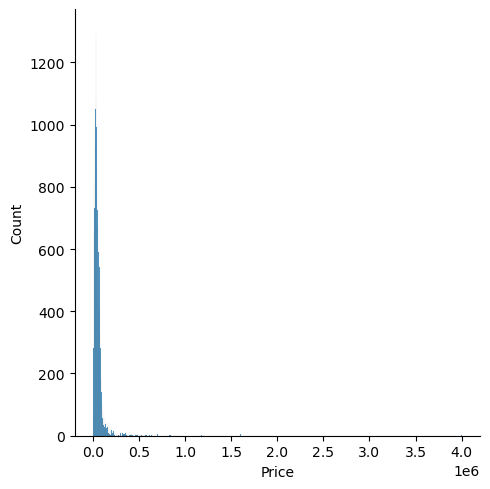

In [6]:
#Distribution
sns.displot(df['Price'])

<Axes: xlabel='Price'>

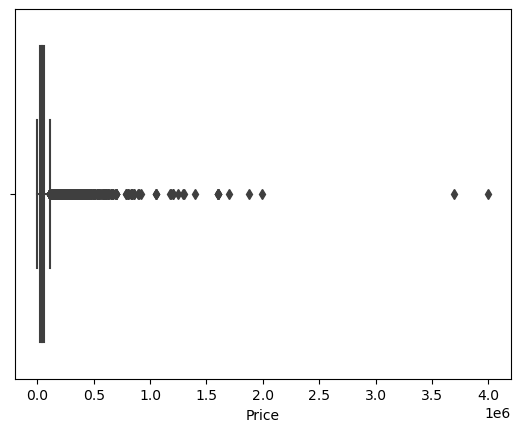

In [7]:
sns.boxplot(x=df["Price"])

# 2. Missing Value
## 2.1 Missing Value on Overall Data

In [8]:
# Total Missing Value
missing_values = df.isnull().sum()
print('Total Missing Value :\n',missing_values)

# Check the missing value in percentage
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
print('\n\nMissing Value Percentage\n',missing_values_percentage)

Total Missing Value :
 Unnamed: 0              0
Year                    0
Make                    0
Model                   0
Kilometres            233
Body Type            1230
 Engine              2062
 Transmission        1344
 Drivetrain          1231
 Exterior Colour     1016
 Interior Colour     7780
 Passengers         12173
 Doors               4587
 Fuel Type            734
 City                6363
 Highway             6363
Price                   0
dtype: int64


Missing Value Percentage
 Unnamed: 0           0.000000
Year                 0.000000
Make                 0.000000
Model                0.000000
Kilometres           0.962889
Body Type            5.083065
 Engine              8.521365
 Transmission        5.554178
 Drivetrain          5.087197
 Exterior Colour     4.198694
 Interior Colour    32.151417
 Passengers         50.305810
 Doors              18.956112
 Fuel Type           3.033309
 City               26.295562
 Highway            26.295562
Price         

Based on result, it appears that there are missing values in several columns. The percentage of missing values varies from 3% to 50%, which means that there may be data quality issues that need to be handled


## 2.2 Filling Missing Data

We will lowercase all values in model, since this will be our primary reference on filling up missing values from other columns.

In [9]:
#Check model 
df['Model'].unique()
#lowercase all models
df['Model'] = df['Model'].str.lower()

### 2.2.1 Kilometers

Starting with kilometers, a potential approach to handling missing values for kilometers is to group the cars by year and calculate the mean kilometers traveled for each year. This assumes that cars generally run about the same number of kilometers every year, and allows us to fill in missing values based on the year of the car. It is worth noting, however, that this approach does have some limitations. For example, it assumes that the cars have not spent too much time in the dealer, and it may not accurately capture variations in usage patterns between different types of cars or drivers. 

In [10]:
# Check all the available year in the data
unique_years = sorted(df['Year'].unique())
print(unique_years)

[1928, 1954, 1957, 1958, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [11]:
#Remove the 'km' string from the column
df['Kilometres'] = df['Kilometres'].str.replace(' km', '')

#Transform the column to integer
df['Kilometres'] = pd.to_numeric(df['Kilometres'], errors='coerce')

In [12]:
#Fill the missing data with mean group by year
df['Kilometres'] = df['Kilometres'].fillna(df.groupby('Year')['Kilometres'].transform('mean'))

# Drop the remaining missing values
df.dropna(subset=['Kilometres'], inplace=True)

### 2.2.2 Body Type

In [13]:
# Fill missing body type with same model
df['Body Type'] = df.groupby('Model')['Body Type'].ffill().bfill()

### 2.2.3 Engine
There are numerous variation of engine in this column, we will only extract the number of cylinder in cars. Using 3 types regex patterns to extract the number. 

In [15]:
import re

# define a function to extract the number from the string
def extract_num(s):
    match1 = re.search('(?<=[IVL])-?([0-9]+)(?=$|\s)', s) # Extract number after the character V,L, or I
    match2 = re.search('(\d+)\s?-?(?i)\w*cyl\w*', s) # Extract number before the word 'cyl'
    match3 = re.search('(?i).*electric.*', s) # Fill electric cars cylinder with 0
    if match1:
        if int(match1.group(1)) <=12:
            return int(match1.group(1))
    elif match2:
        if int(match2.group(1)) <=12:
            return int(match2.group(1))
    elif match3:
        return 0
    else:
        return None

df[' Engine'] = df[' Engine'].astype('str')
df['Cylinder'] = df[' Engine'].apply(extract_num)

C:\Users\DEBANJAN\AppData\Local\Temp\ipykernel_28580\542807230.py:6: DeprecationWarning: Flags not at the start of the expression '(\\d+)\\s?-?(?i)\\w*cyl' (truncated) but at position 10
  match2 = re.search('(\d+)\s?-?(?i)\w*cyl\w*', s) # Extract number before the word 'cyl'


In [16]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(df['Cylinder'].unique())
#print(df[' Engine'].unique())
#len(df['Cylinder'].unique())

[ 6.  4. nan  8.  0. 10.  5. 12.  3.  1.  2.]


Check on irregular values on cars with 1 or 2 cylinders. It seems that Porche Cayenne on rows 6628 is an input error as all other cars with the same model have 6 cylinders.

In [17]:
#Check the 1 cylinder car
print(df[df['Cylinder']== 1])

#Fix the data for Cayenne
df.at[6628, 'Cylinder'] = '6'

#Check the 2 cylinder car
print(df[df['Cylinder'] == 2])

      Unnamed: 0  Year     Make    Model  Kilometres Body Type  \
6628        6628  2015  Porsche  cayenne     97677.0       SUV   

                 Engine  Transmission  Drivetrain  Exterior Colour  \
6628  1 Cylinder Engine     Automatic         AWD   Moonlight Blue   

      Interior Colour   Passengers  Doors        Fuel Type  City  Highway  \
6628            Brown          5.0      5  Gasoline Hybrid   NaN      NaN   

      Price  Cylinder  
6628  47900       1.0  
       Unnamed: 0  Year    Make      Model  Kilometres Body Type  \
22587       22587  2010  Suzuki  boulevard     24413.0       SUV   

                  Engine  Transmission  Drivetrain  Exterior Colour  \
22587  2 Cylinder Engine           NaN         NaN            Black   

       Interior Colour   Passengers  Doors  Fuel Type  City  Highway  Price  \
22587              NaN          NaN    NaN        Gas   NaN      NaN   8980   

      Cylinder  
22587      2.0  


Fill the missing data with values from the same model and body type

In [18]:
# Fill missing Cylinder type with same model
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df['Cylinder'].fillna(df.groupby('Model')['Cylinder'].transform('median'), inplace = True)

#Fill the rest with the same body type
df['Cylinder'].fillna(df.groupby('Body Type')['Cylinder'].transform('median'), inplace = True)
df['Cylinder'] = df['Cylinder'].astype(int)

### 2.2.4 Transmission
We will split transmission into 2 columns : Speed and Type
* Speed : number of speed transmission
* Type : Type of transmission, value could be Automatic, Manual, CVT, and Sequential

In [19]:
#Split the transmission column to speed and type
df[['Speed', 'Type']] = df[' Transmission'].str.extract(r'^(\d+)?\s?(.*)')

#Most electric car have 1 speed type
df['Speed'] = df['Speed'].fillna(df['Cylinder'].apply(lambda x: 1 if x==0 else None))

In [20]:
#Fill with the same model, sorted by year
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df['Speed'] = df['Speed'].fillna(df.sort_values('Year').groupby('Model')['Speed'].ffill().bfill())
df['Speed'] = df['Speed'].astype(int)

In [21]:
df['Type'] = df['Type'].str.extract('(Automatic|Manual|Sequential|CVT)', expand=False)
df['Type'] = df.groupby('Model')['Type'].ffill().bfill()

### 2.2.5 Drivetrain

In [22]:
# Fill missing Drive train type with same model
df[' Drivetrain'] = df.groupby('Model')[ ' Drivetrain'].ffill().bfill()

### 2.2.6 Exterior Colour
This part is a big hassle to clean, as we have to categories different types of colour into more general colours

In [23]:
def extract_main_color(color_str):
    main_color = ['white', 'black', 'blue', 'red', 'gray', 'silver', 'yellow', 'green', 'brown', 'orange', 'purple', 'gold']
    color_lower = color_str.lower()
    color_lower = re.sub(r'\b(thunder|quartz|metallescent|shadow|aluminum|grey|graphite|charcoal|ash|sterling|steel|gun|granite|magnetic|billet|metal)\b', r'gray', color_lower)
    color_lower = re.sub(r'\b(burgundy|maroon|scarlet|rosso|ruby|molten|flame)\b', r'red', color_lower)
    color_lower = re.sub(r'\b(bianco|chalk|powder|aspen|avalanche|polar|snow|cream|iridescent)\b', r'white', color_lower)
    color_lower = re.sub(r'\b(sea|area|earl|blu|wave|marine|frostbite)\b', r'blue', color_lower)
    color_lower = re.sub(r'\b(mango|tangerine|punk|sunset|papaya)\b', r'orange', color_lower)
    color_lower = re.sub(r'\b(dark|ebony|titanium|onyx|nero|rocky|midnight)\b', r'black', color_lower)
    color_lower = re.sub(r'\b(beige|dust|tan|copper|dusk|chestnut|desert|mahogany|nickel|palladium|birch)\b', r'brown', color_lower)
    color_lower = re.sub(r'\b(platinum|mist|frost|moon)\b', r'silver', color_lower)
    color_lower = re.sub(r'\b(velocity)\b', r'yellow', color_lower)
    color_lower = re.sub(r'\b(passion)\b', r'purple', color_lower)
    color_lower = re.sub(r'\b(olive|sublime)\b', r'green', color_lower)
    for color in main_color:
        if re.search(r'w*'+ color+ '\w*', color_lower):
            return color
    return None
df[' Exterior Colour'] = df[' Exterior Colour'].astype(str)  
df['Main Color'] = df[' Exterior Colour'].apply(extract_main_color)

In [24]:
df['Main Color'].value_counts().head(30)

black     7113
white     6017
gray      4022
blue      2215
silver    1504
red       1347
green      233
brown      174
orange     118
yellow     101
gold        35
purple      18
Name: Main Color, dtype: int64

In [25]:
# Fill missing Exterior Color type with same model
df['Main Color'] = df.groupby('Model')[ 'Main Color'].ffill().bfill()

### 2.2.7 Interior Colour
Similar process from above

In [26]:
df[' Interior Colour'].value_counts()

Black         12699
Grey           1065
Charcoal        569
Red             527
Brown           422
Beige           395
Tan             218
White           158
Dark Grey       135
Cream            68
Light Grey       64
Blue             50
Orange           37
Stone             5
Burgundy          4
Taupe             1
Name:  Interior Colour, dtype: int64

In [27]:
def extract_int_color(color_str):
    main_color = ['black','grey','red','white','blue','orange','cream']
    color_lower = color_str.lower()
    color_lower = re.sub(r'\b(stone|charcoal)\b', r'gray', color_lower)
    color_lower = re.sub(r'\b(burgundy)\b', r'red', color_lower)
    color_lower = re.sub(r'\b(taupe|beige|tan)\b', r'brown', color_lower)
    for color in main_color:
        if re.search(r'w*'+ color+ '\w*', color_lower):
            return color
    return None
df[' Interior Colour'] = df[' Interior Colour'].astype(str)  
df['Int Colour'] = df[' Interior Colour'].apply(extract_int_color)

In [28]:
# Fill missing Exterior Color type with same model
df['Int Colour'] = df.groupby('Model')[ 'Int Colour'].ffill().bfill()

### 2.2.7 Passangers
Theres more than 50% missing data on passengers, we will just drop this column

In [29]:
# Drop Passenger Column
df = df.drop(' Passengers', axis=1)

### 2.2.8 Doors
There are mixed value between string and integer, we will extract only the number

In [30]:
df[' Doors'].unique()
df[' Doors'].value_counts()

4                     14313
2                      2906
4 doors                1004
5                       675
5 doors                 361
2 doors                 219
3                        89
3 doors                  39
Other/Donât Know        3
2.0                       1
Name:  Doors, dtype: int64

In [31]:
def extract_doors(s):
    match = re.search(r'\d+\.?\d*' , s) 
    if match:
        return float(match.group()) 
    else:
        return np.nan
df[' Doors'] = df[' Doors'].astype(str) 
df['Doors'] = df[' Doors'].apply(extract_doors)

In [32]:
df['Doors'].value_counts()

4.0    15317
2.0     3126
5.0     1036
3.0      128
Name: Doors, dtype: int64

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df['Doors'].fillna(df.groupby('Model')['Doors'].transform('median'), inplace = True)
    
#Fill the rest with the same body type
df['Doors'].fillna(df.groupby('Body Type')['Doors'].transform('median'), inplace = True)
df['Doors'] = df['Doors'].astype(int)

### 2.2.9 Fuel Type
Similar process with color, we will only keep categories with Hybrid, Electric, Gas, and Diesel.

In [34]:
df[' Fuel Type'].value_counts()

Gas                         17669
Gasoline                     1409
Regular Unleaded              970
Premium Unleaded              921
Electric                      886
Gasoline Hybrid               549
Diesel                        510
Flexible                      350
Other                         124
Gasoline - Hybrid              27
E85- Gasoline(Flex Fuel)       19
Gas/Electric Hybrid            13
Gasoline Fuel                  13
Other/Donât Know              2
Gaseous Fuel Compatible         1
Name:  Fuel Type, dtype: int64

In [35]:
def extract_fuel(fueltype):
    fuel_type = ['hybrid','electric','gas','diesel']
    fuel_lower = fueltype.lower()
    fuel_lower = re.sub(r'\b(hybrid)\b', r'hybrid', fuel_lower)
    fuel_lower = re.sub(r'\b(unleaded|gasoline|gaseous|flexible|flex)\b', r'gas', fuel_lower)
    for fuel in fuel_type:
        if re.search(r'w*'+ fuel + '\w*', fuel_lower):
            return fuel
    return None
df[' Fuel Type'] = df[' Fuel Type'].astype(str)  
df['Fuel Type'] = df[' Fuel Type'].apply(extract_fuel)

In [36]:
df['Fuel Type'].value_counts()

gas         21352
electric      886
hybrid        589
diesel        510
Name: Fuel Type, dtype: int64

In [37]:
# Fill missing Fuel type type with same model
df['Fuel Type'] = df.groupby('Model')[ 'Fuel Type'].ffill().bfill()

### 2.2.10 City and Highway
Since the data is recorded with string mixed, and some of the data are in range, we will only extract the first float value from each rows.

In [38]:
def extract_first_float(s):
    match = re.search(r"[-+]?\d*\.\d+", s)
    if match:
        return float(match.group())
    else:
        return None

df[' City'] = df[' City'].astype(str) 
df[' Highway'] = df[' Highway'].astype(str) 
df['City'] = df[' City'].apply(extract_first_float)
df['Highway'] = df[' Highway'].apply(extract_first_float)

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df['City'].fillna(df.groupby('Model')['City'].transform('median'), inplace = True)
    df['Highway'].fillna(df.groupby('Model')['Highway'].transform('median'), inplace = True)

#Fill the rest with the same body type
df['City'].fillna(df.groupby('Body Type')['City'].transform('median'), inplace = True)
df['Highway'].fillna(df.groupby('Body Type')['Highway'].transform('median'), inplace = True)

In [40]:
df[df['City'].isnull()]
#only 1 rows where its still missing, we can drop this
df = df.dropna(subset=['City'])

In [41]:
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
print('\n\nMissing Value Percentage\n',missing_values_percentage)



Missing Value Percentage
 Unnamed: 0          0.000000
Year                0.000000
Make                0.000000
Model               0.000000
Kilometres          0.000000
Body Type           0.000000
 Engine             0.000000
 Transmission       5.550504
 Drivetrain         0.000000
 Exterior Colour    0.000000
 Interior Colour    0.000000
 Doors              0.000000
 Fuel Type          0.000000
 City               0.000000
 Highway            0.000000
Price               0.000000
Cylinder            0.000000
Speed               0.000000
Type                0.000000
Main Color          0.000000
Int Colour          0.000000
Doors               0.000000
Fuel Type           0.000000
City                0.000000
Highway             0.000000
dtype: float64


### 2.3 Drop Uneccesary Column
Since we have assigned most of these columns to a new variable, we can drop these columns

In [42]:
df = df.drop(['Unnamed: 0',' Engine',' Transmission',' Exterior Colour',' Interior Colour',' Doors',' Fuel Type',' City',' Highway'], axis=1)

In [43]:
df.dtypes

Year             int64
Make            object
Model           object
Kilometres     float64
Body Type       object
 Drivetrain     object
Price            int64
Cylinder         int32
Speed            int32
Type            object
Main Color      object
Int Colour      object
Doors            int32
Fuel Type       object
City           float64
Highway        float64
dtype: object

# 3. Feature Engineer Numerical Variable
## 3.1 Checking the most important numerical variable
### 3.1.1 Correlation Analysis

<Axes: >

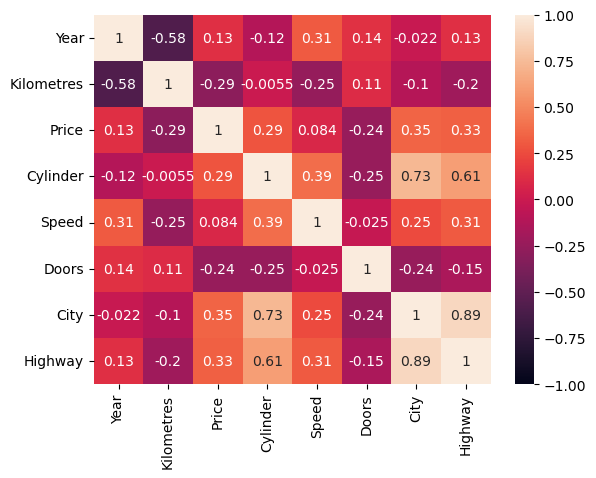

In [44]:
sns.heatmap(df.corr(),vmin = -1, vmax = 1, annot = True)

City, Highway, and Cylinder have moderate correlation with price, while kilometres have moderate negative correlation with price

### 3.1.2 Bivariate Analysis

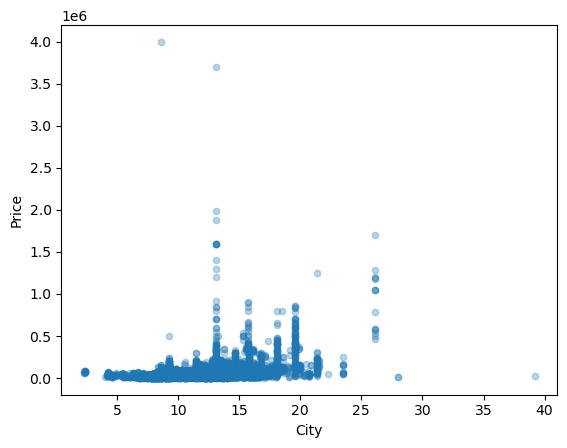

In [45]:
data = pd.concat([df['Price'], df['City']], axis=1)
data.plot.scatter(x='City', y='Price', alpha=0.3);

<Axes: xlabel='Highway', ylabel='Price'>

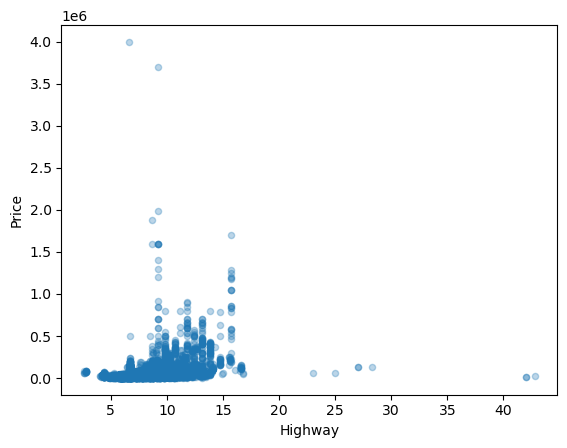

In [46]:
data = pd.concat([df['Price'], df['Highway']], axis=1)
data.plot.scatter(x='Highway', y='Price', alpha=0.3)

<Axes: xlabel='Kilometres', ylabel='Price'>

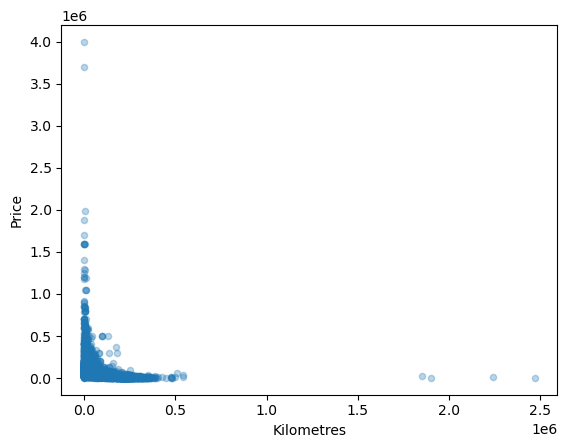

In [47]:
data = pd.concat([df['Price'], df['Kilometres']], axis=1)
data.plot.scatter(x='Kilometres', y='Price', alpha=0.3)

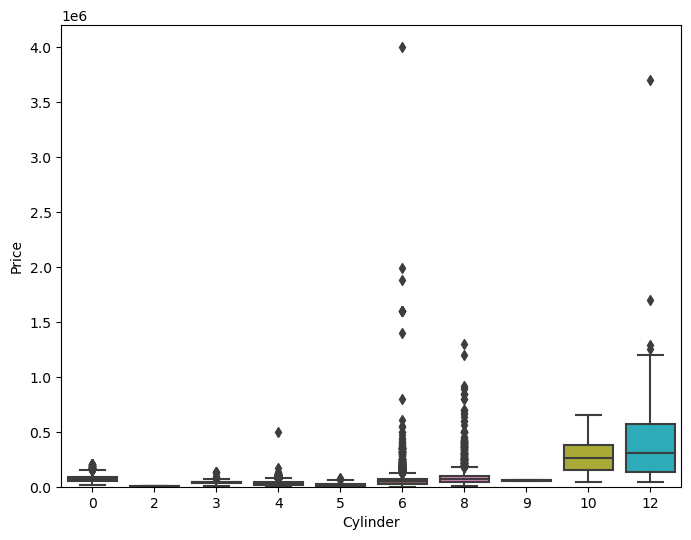

In [48]:
var = 'Cylinder'
data = pd.concat([df['Price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0);

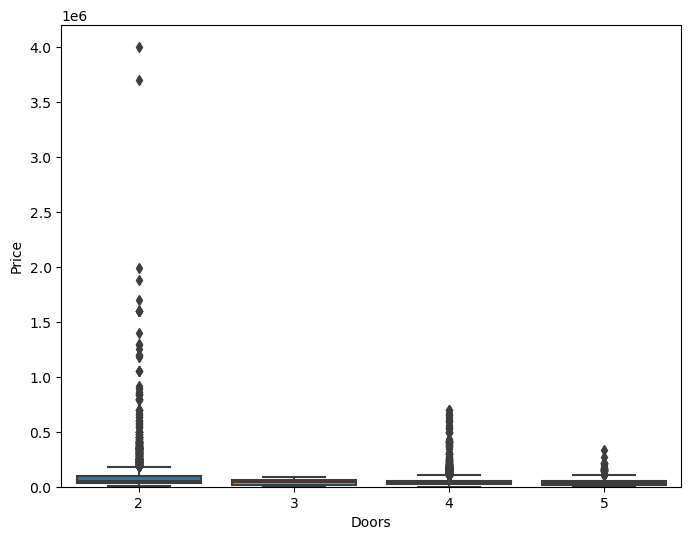

In [49]:
var = 'Doors'
data = pd.concat([df['Price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0);

## 3.2 Check on Normality
### 3.2.1 Price

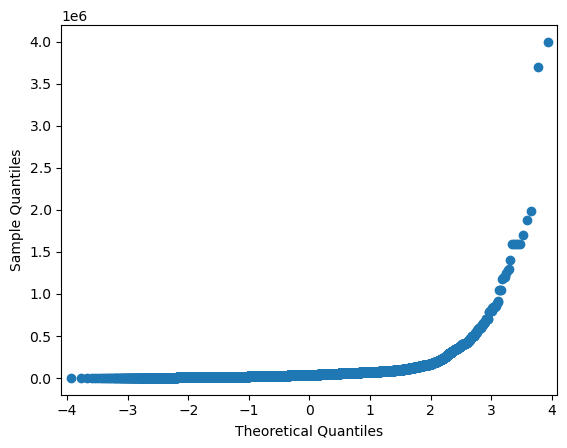

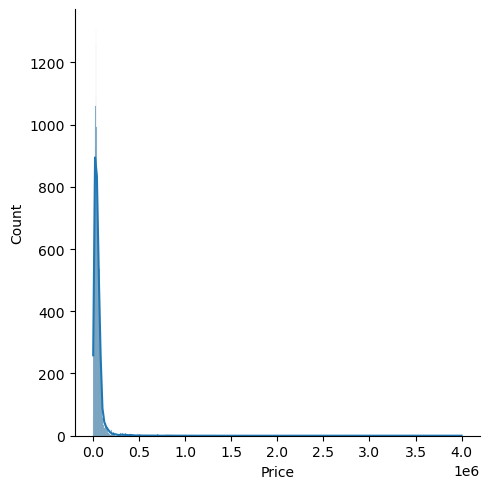

In [50]:
import statsmodels.api as sm
sm.qqplot(df['Price'])
sns.displot(df['Price'], kde=True)
plt.show()

### 3.2.2 Kilometres

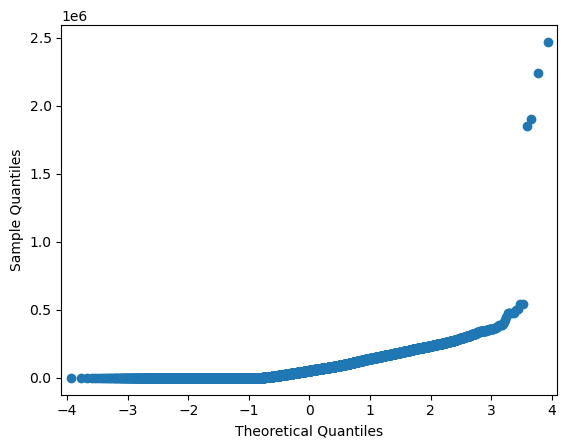

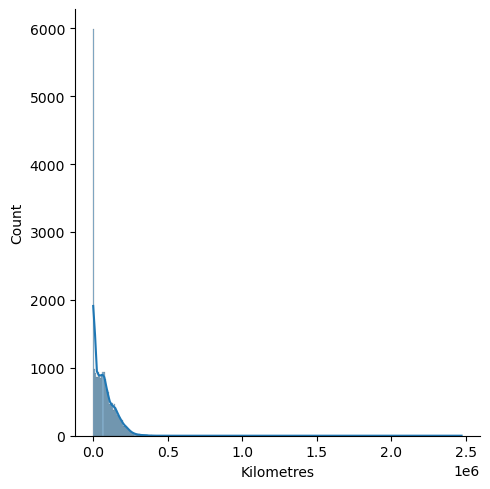

In [51]:
sm.qqplot(df['Kilometres'])
sns.displot(df['Kilometres'], kde=True)
plt.show()

### 3.2.3 City

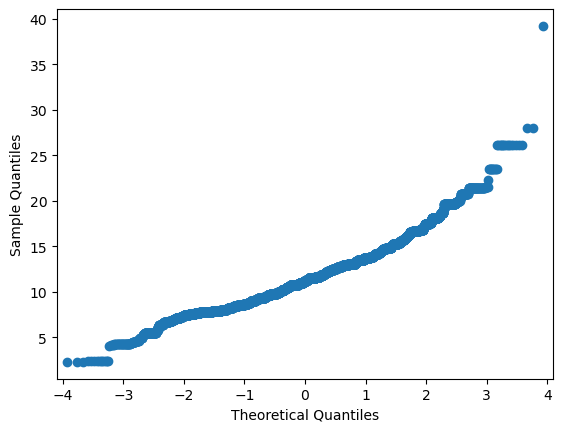

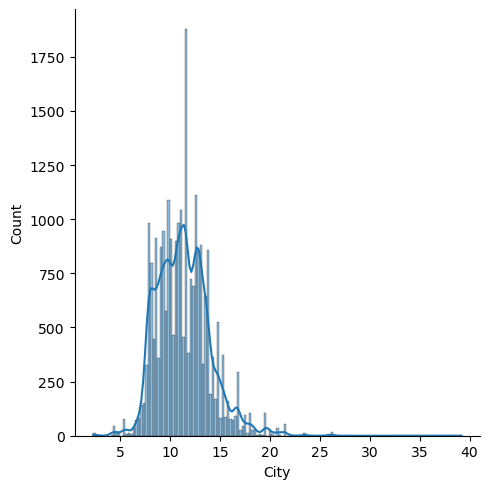

In [52]:
sm.qqplot(df['City'])
sns.displot(df['City'], kde=True)
plt.show()

### 3.2.4 Highway

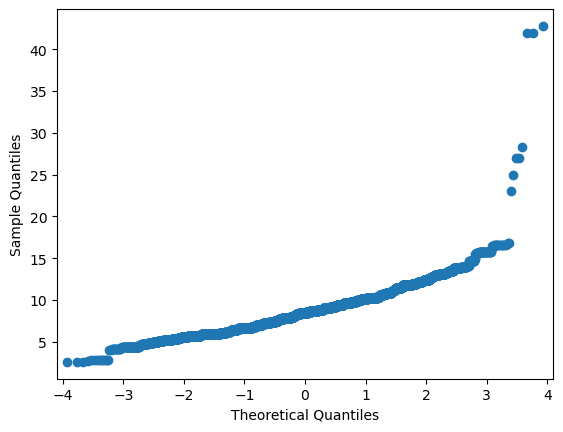

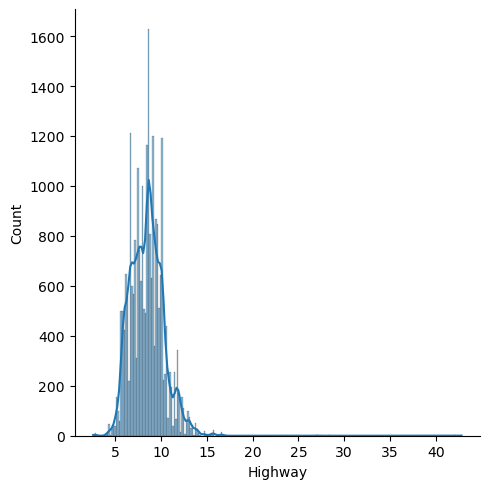

In [53]:
sm.qqplot(df['Highway'])
sns.displot(df['Highway'], kde=True)
plt.show()

# 4. Outliers

### 4.1 Remove Outliers in City and Highway

In [54]:
# Set the 0.5% and 99.5% quantiles of the distribution
cq005 = df['City'].quantile(0.005)
cq995 = df['City'].quantile(0.995)
print(cq005,cq995)
hq005 = df['Highway'].quantile(0.005)
hq995 = df['Highway'].quantile(0.995)
print(hq005,hq995)

5.5 20.700000000000003
4.9 13.8


In [55]:
# Drop the lowest 0.05% and highest 99.5%
df = df[(df['City'] >= cq005) & (df['City'] <= cq995)]
df = df[(df['Highway'] >= hq005) & (df['Highway'] <= hq995)]

### 4.2 Remove Outliers in Kilometres

In [56]:
kmq005 = df['Kilometres'].quantile(0.005)
kmq995 = df['Kilometres'].quantile(0.995)
print(kmq005,kmq995)

0.0 300070.16


In [57]:
print('Percentage of new car :',df['Kilometres'].value_counts()[0]/len(df)*100,'%')

Percentage of new car : 2.8258048310796666 %


Since the regression is primarily focused on new cars, we will drop new cars with 0 km

In [58]:
df = df[df['Kilometres'] > 0]

In [59]:
km = df['Kilometres'][:,np.newaxis]
high_range= km[km[:,0].argsort()][-10:]
print('\nouter range (high) of the distribution:')
print(high_range)


outer range (high) of the distribution:
[[ 480000.]
 [ 480000.]
 [ 500000.]
 [ 510000.]
 [ 540000.]
 [ 545000.]
 [1854445.]
 [1900000.]
 [2240000.]
 [2470000.]]


Exclude the kilometres value more than 1000000

In [60]:
df = df[df['Kilometres'] < 1000000]

### 4.3 Remove Outliers in Price

In [61]:
price = df['Price'][:,np.newaxis]
low_range = price[price[:,0].argsort()][:10]
high_range= price[price[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[ 500]
 [1500]
 [1500]
 [1800]
 [1900]
 [1999]
 [2000]
 [2000]
 [2000]
 [2200]]

outer range (high) of the distribution:
[[1399000]
 [1599900]
 [1599998]
 [1599998]
 [1599998]
 [1599998]
 [1875000]
 [1990000]
 [3699998]
 [3999998]]


In [62]:
# Set the 0.5% and 99.5% quantiles of the distribution
pq005 = df['Price'].quantile(0.005)
pq995 = df['Price'].quantile(0.995)
print(pq005,pq995)

3992.105 399884.92000000004


In [63]:
# Drop the lowest 0.05% and highest 99.5%
df = df[(df['Price'] >= pq005) & (df['Price'] <= pq995)]

# 5. Data Normality
## 5.1 Normalize Data
### 5.1.1 Normalize Price

In [64]:
# Log Transform 
df['Price'] = np.log(df['Price'])

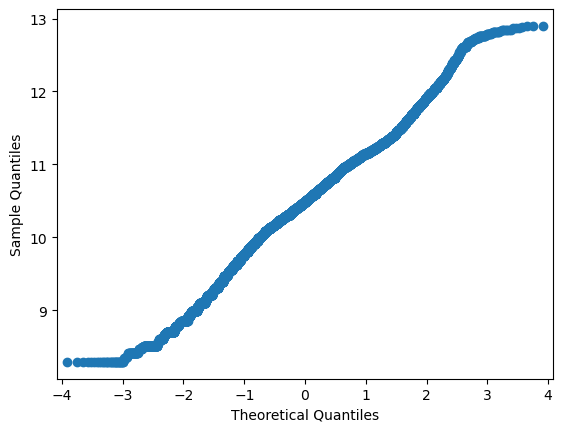

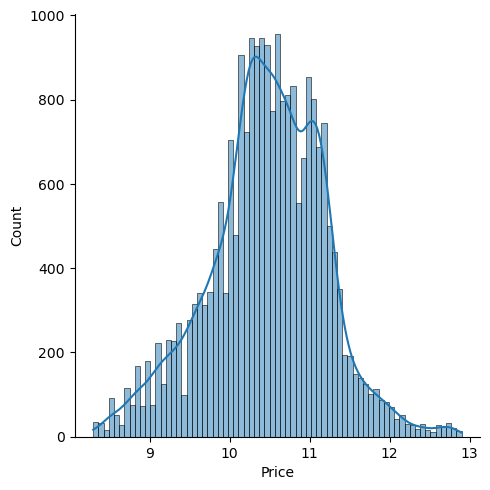

In [65]:
sm.qqplot(df['Price'])
sns.displot(df['Price'], kde=True)
plt.show()

### 5.1.2 Normalize Kilometres

In [66]:
df['Kilometres'] = boxcox1p(df['Kilometres'], boxcox_normmax(df['Kilometres'] + 1))

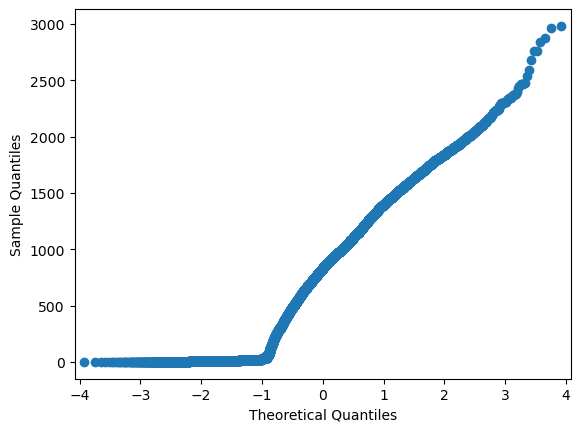

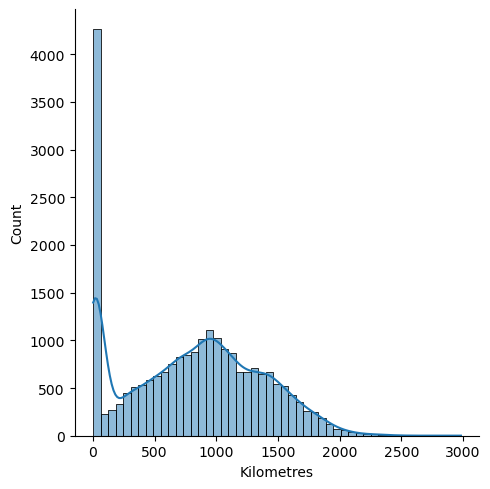

In [67]:
sm.qqplot(df['Kilometres'])
sns.displot(df['Kilometres'], kde=True)
plt.show()

### 5.1.3 Normalize City 

In [68]:
df['City'] = boxcox1p(df['City'], boxcox_normmax(df['City'] + 1))

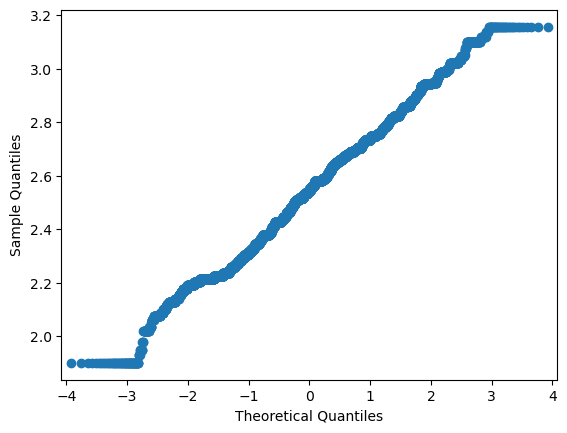

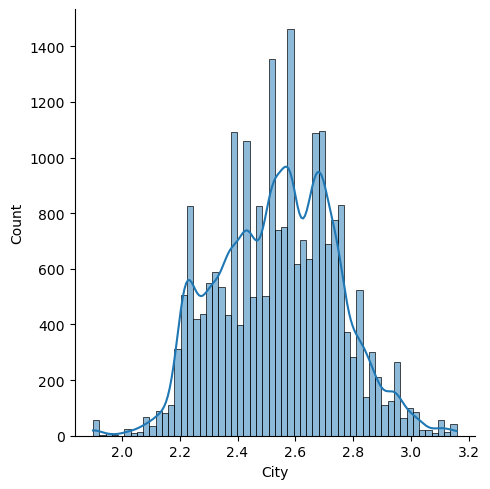

In [69]:
sm.qqplot(df['City'])
sns.displot(df['City'], kde=True)
plt.show()

### 5.1.3 Normalize Highway

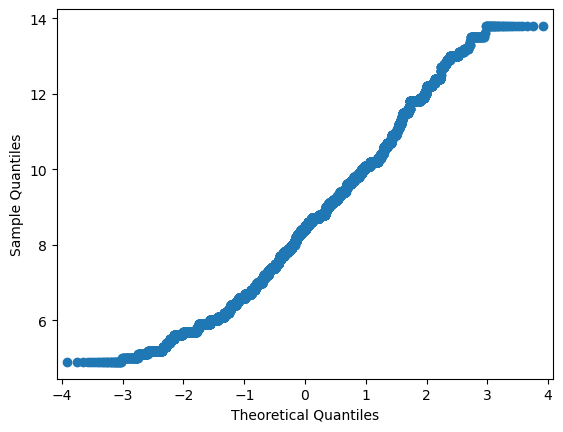

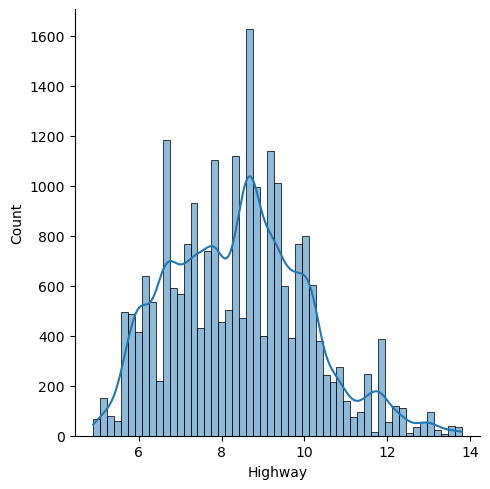

In [70]:
sm.qqplot(df['Highway'])
sns.displot(df['Highway'], kde=True)
plt.show()

## 5.2 Check on Skewness

In [71]:
skewness = df[['Price','Kilometres','City','Highway']].skew()
print(skewness)

Price        -0.173296
Kilometres    0.111142
City          0.016037
Highway       0.357556
dtype: float64


# 6. Feature Engineer Categorical Variable
## Encode categorical features

In [72]:
df = pd.get_dummies(df).reset_index(drop=True)

In [73]:
df.head(10)

,Year,Kilometres,Price,Cylinder,Speed,Doors,City,Highway,Make_Acura,Make_Alfa Romeo,...,Int Colour_blue,Int Colour_cream,Int Colour_grey,Int Colour_orange,Int Colour_red,Int Colour_white,Fuel Type_diesel,Fuel Type_electric,Fuel Type_gas,Fuel Type_hybrid
0,2019,803.754393,10.689214,6,9,4,2.635700,9.0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,2018,992.324595,10.504684,6,9,4,2.666854,9.0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2019,615.409199,10.618592,4,10,4,2.536340,8.6,1,0,...,0,0,0,0,0,0,0,0,1,0
3,2020,783.497898,10.705467,4,10,4,2.536340,8.6,1,0,...,0,0,0,0,0,0,0,0,1,0
4,2021,923.995288,10.757669,4,10,4,2.562067,9.1,1,0,...,0,0,0,0,1,0,0,0,1,0
5,2022,593.771038,11.016972,6,9,4,2.666854,9.4,1,0,...,0,0,0,0,1,0,0,0,1,0
6,2020,558.392088,10.801594,4,10,4,2.562067,9.1,1,0,...,0,0,0,0,0,0,0,0,1,0
7,2019,629.608172,10.505040,6,9,4,2.570506,7.7,1,0,...,0,0,0,0,0,0,0,0,1,0
8,2020,868.646265,10.558284,4,10,4,2.536340,8.6,1,0,...,0,0,0,0,0,0,0,0,1,0
9,2009,1293.710818,9.350102,4,6,4,2.492022,7.0,1,0,...,0,0,0,0,0,0,0,0,1,0


# 7. Modelling

## 7.1 Split the data

In [74]:
# Split the data
X = df.drop('Price', axis=1).values
y = df['Price'].values

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## 7.2 Train and Test Model
### 7.2.1 Lasso Regression

Lasso() 

MSE: 0.24409624975576633
RMSE: 0.4940609777707265
R2: 0.535101892985536


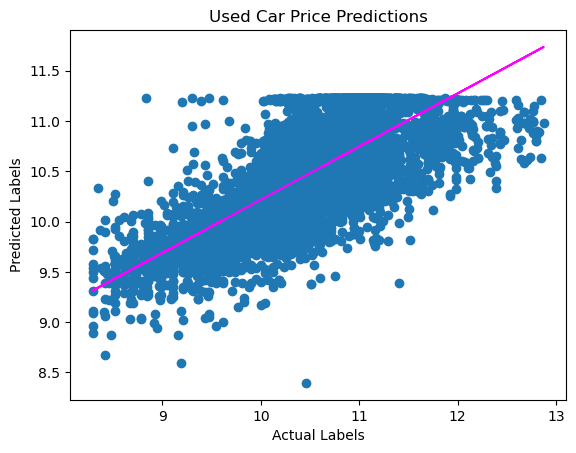

In [75]:
# Fit a Lasso model on the training set
model = Lasso().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Used Car Price Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### 7.2.2 Decision Tree

DecisionTreeRegressor() 

MSE: 0.05512956356614675
RMSE: 0.23479685595456073
R2: 0.8950019520247474


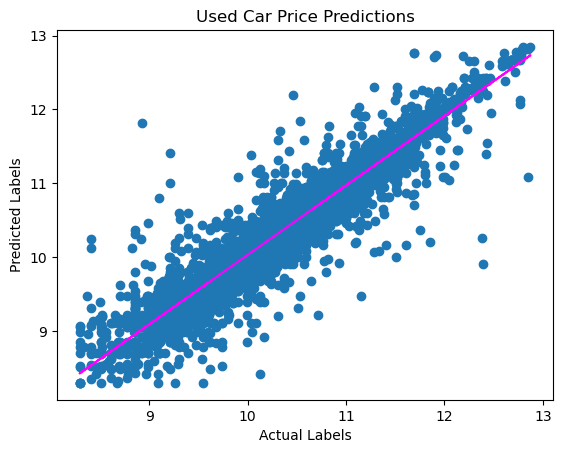

In [76]:
# Train the model
model = DecisionTreeRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Used Car Price Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### 7.2.3 Random Forest Regression

RandomForestRegressor() 

MSE: 0.030852247636293302
RMSE: 0.17564807894279202
R2: 0.9412397710427528


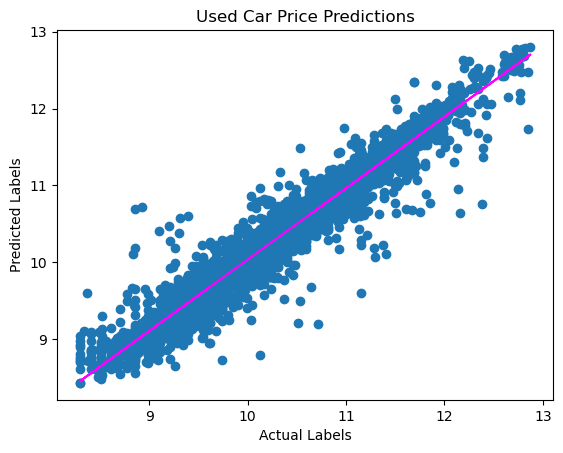

In [77]:
# Train the model
model = RandomForestRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Used Car Price Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### 7.2.5 Support Vector Regression

Pipeline(steps=[('std', StandardScaler()), ('svr', SVR())]) 

MSE: 0.06605134675977367
RMSE: 0.2570045656399389
R2: 0.8742006642662509


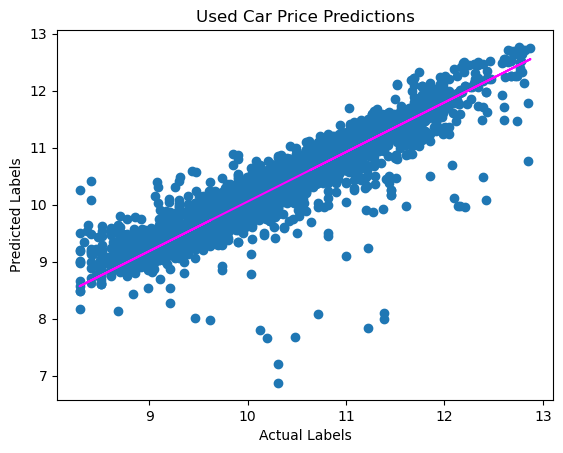

In [79]:
model = Pipeline([('std', StandardScaler()), ('svr', SVR())])
 
# fitting the data in the pipe
model.fit(X_train, y_train)

print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Used Car Price Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()